In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras import layers, optimizers

# Methods

`make_sequence` turns the samples into an array of sequential samples of specified length.  
`make_label` adjusts accordingly the corresponding label of each sequential sample.  
`eval_pred` evaluates the predictions of a model by outputting the distance between each prediction to its actual label.

In [2]:
def make_sequence(array, length):
    sequence = []
    for i in range(len(array)-length):
        sequence.append(array[i: (i+length)])
    return np.asarray(sequence)

def make_label(array, offset):
    return np.asarray(array[offset:])
    
def eval_pred(preds, label):
    diff = np.array([])
    for pred in range(len(label)):
        diff = np.append(diff, abs(y_test[pred]-preds[pred]))

    return diff

# Organising Data

In [3]:
df = pd.read_csv('btc-price-iso.csv', engine='python')
df.head()

,timestamp,market-cap,total-btc,n-transactions-avg,block-size-avg(MB),market-price
0,01/04/2019 00:00,7.208649e+10,17620750.0,377350.7143,1.205358,4114.16
1,02/04/2019 00:00,7.276155e+10,17622075.0,382363.8571,1.215507,4152.53
2,03/04/2019 00:00,8.456594e+10,17623412.5,379087.2857,1.248330,4882.88
3,04/04/2019 00:00,8.902573e+10,17624737.5,373510.4286,1.212958,4959.81
4,05/04/2019 00:00,9.259859e+10,17626075.0,375978.0000,1.240969,4911.24


Convert Strings to Datetime.

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
df.head()

,timestamp,market-cap,total-btc,n-transactions-avg,block-size-avg(MB),market-price
0,2019-04-01,7.208649e+10,17620750.0,377350.7143,1.205358,4114.16
1,2019-04-02,7.276155e+10,17622075.0,382363.8571,1.215507,4152.53
2,2019-04-03,8.456594e+10,17623412.5,379087.2857,1.248330,4882.88
3,2019-04-04,8.902573e+10,17624737.5,373510.4286,1.212958,4959.81
4,2019-04-05,9.259859e+10,17626075.0,375978.0000,1.240969,4911.24


Break each Datetime down into separate day, month, year columns for easier access.

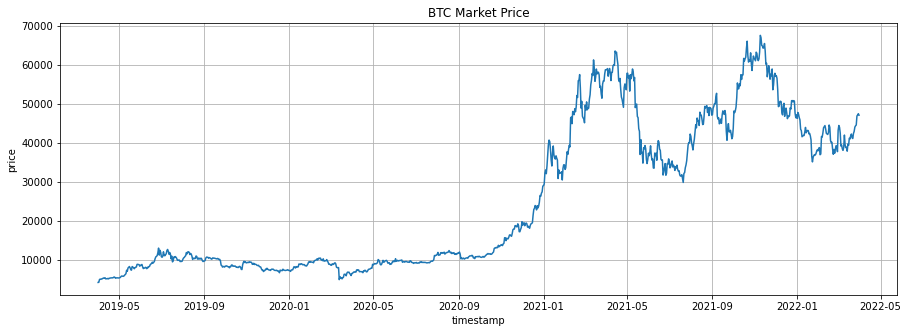

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df.iloc[:]['timestamp'], df.iloc[:]['market-price'])
plt.title('BTC Market Price')
plt.xlabel('timestamp')
plt.ylabel('price')
plt.grid()
plt.show()

# Preparing Data

In [6]:
df.head()

,timestamp,market-cap,total-btc,n-transactions-avg,block-size-avg(MB),market-price
0,2019-04-01,7.208649e+10,17620750.0,377350.7143,1.205358,4114.16
1,2019-04-02,7.276155e+10,17622075.0,382363.8571,1.215507,4152.53
2,2019-04-03,8.456594e+10,17623412.5,379087.2857,1.248330,4882.88
3,2019-04-04,8.902573e+10,17624737.5,373510.4286,1.212958,4959.81
4,2019-04-05,9.259859e+10,17626075.0,375978.0000,1.240969,4911.24


### Scaling Data

In [7]:
scaler = preprocessing.StandardScaler()

# Features to be scaled
scaled_data = scaler.fit_transform(df[['block-size-avg(MB)', 'n-transactions-avg', 'total-btc', 'market-cap', 'market-price']])

Make a copy of the original Dataframe for manipulation.

In [8]:
scaled_df = df.copy()

Replace the features by the scaled version.

In [9]:
scaled_df['block-size-avg(MB)'] = scaled_data[:, 0]
scaled_df['n-transactions-avg'] = scaled_data[:, 1]
scaled_df['total-btc'] = scaled_data[:, 2]
scaled_df['market-cap'] = scaled_data[:, 3]
scaled_df['market-price'] = scaled_data[:, 4]
scaled_df.head()

,timestamp,market-cap,total-btc,n-transactions-avg,block-size-avg(MB),market-price
0,2019-04-01,-0.829039,-1.977428,2.048417,0.191036,-1.099172
1,2019-04-02,-0.826768,-1.973361,2.175777,0.254517,-1.097153
2,2019-04-03,-0.787051,-1.969256,2.092535,0.459827,-1.058729
3,2019-04-04,-0.772045,-1.965190,1.950853,0.238574,-1.054682
4,2019-04-05,-0.760024,-1.961085,2.013542,0.413783,-1.057237


### Splitting the Dataset

In [10]:
training, testing = model_selection.train_test_split(scaled_df, shuffle=False)
print('Dataset size: %d' % (len(scaled_df)))
print('Training size: %d' % (len(training)))
print('Testing size: %d' % (len(testing)))

Dataset size: 1096
Training size: 822
Testing size: 274


Select relevant features to train and test.

In [11]:
X_train = training[['market-price', 'block-size-avg(MB)', 'n-transactions-avg', 'total-btc', 'market-cap']].to_numpy()
y_train = training['market-price'].to_numpy()

In [12]:
X_test = testing[['market-price', 'block-size-avg(MB)', 'n-transactions-avg', 'total-btc', 'market-cap']].to_numpy()
y_test = testing['market-price'].to_numpy()

See data train and test.

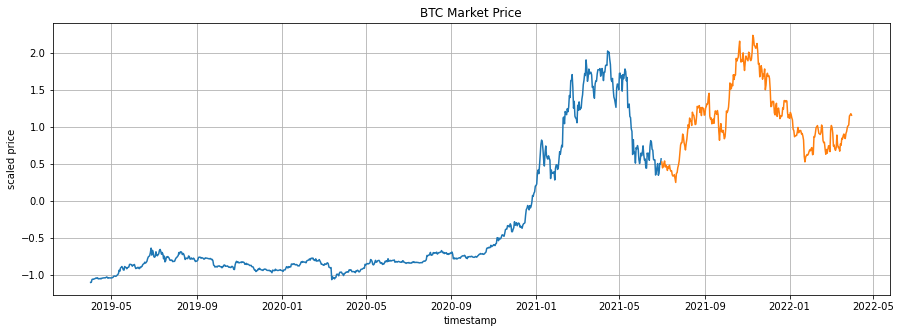

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(training['timestamp'], X_train[:, 0])
plt.plot(testing['timestamp'], X_test[:, 0])
plt.xlabel('timestamp')
plt.ylabel('scaled price')
plt.title('BTC Market Price')
plt.grid()
plt.show()

### Making Each Sample Sequential

In [14]:
length = 8

In [15]:
X_train = make_sequence(X_train, length)
X_test  = make_sequence(X_test, length)
y_train = make_label(y_train, length)
y_test = make_label(y_test, length)

After some slicing,   
`X_train` shape: `(814, 8, 5)`  
`y_train` shape: `(814, )`   
`X_test` shape: `(266, 8, 5)`  
`X_train` shape: `(266, )`

See data for one sequence with its corresponding label which the price for the next timestamp.

In [16]:
# plt.figure(figsize=(15, 5))
# plt.plot(training[0: 8]['timestamp'], X_train[0, :, 0])
# plt.scatter(training[8: 9]['timestamp'], y_train[0], marker='o', color='red')
# plt.title('BTC Market Price for One Sequence')
# plt.xlabel('timestamp')
# plt.ylabel('scaled price')
# plt.grid()
# plt.show()

# Building Models

## LSTM

Choose an optimiser for the model.

In [17]:
optim = optimizers.RMSprop()

Start building an LSTM model.

In [18]:
lstm = tf.keras.Sequential()
lstm.add(layers.LSTM(64, return_sequences=True))
lstm.add(layers.Dropout(0.5))
lstm.add(layers.LSTM(20,return_sequences=False))
lstm.add(layers.Dropout(0.5))
lstm.add(layers.Dense(1))
lstm.compile(loss='mse', optimizer=optim)

Train the model.

In [19]:
lstm.fit(X_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
26/26 [==============================] - 7s 6ms/step - loss: 0.1980
Epoch 2/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0736
Epoch 3/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0677
Epoch 4/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0746
Epoch 5/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0594
Epoch 6/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0615
Epoch 7/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0672
Epoch 8/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0650
Epoch 9/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0519
Epoch 10/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0560
Epoch 11/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0535A: 0s - loss: 0.0
Epoch 12/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0520
Epoch 13/200
26/26 [

26/26 [==============================] - 0s 14ms/step - loss: 0.0434: 0s - loss: 0.044
Epoch 102/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0403
Epoch 103/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0399
Epoch 104/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0423
Epoch 105/200
26/26 [==============================] - 0s 12ms/step - loss: 0.0399
Epoch 106/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0524
Epoch 107/200
26/26 [==============================] - 0s 10ms/step - loss: 0.0413
Epoch 108/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0415
Epoch 109/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0499
Epoch 110/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0440
Epoch 111/200
26/26 [==============================] - 0s 11ms/step - loss: 0.0362
Epoch 112/200
26/26 [==============================] - 0s 8ms/step - loss: 0.0425
Epoch 

26/26 [==============================] - 0s 6ms/step - loss: 0.0409


In [20]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 64)             17920     
_________________________________________________________________
dropout (Dropout)            (None, 8, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                6800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 24,741
Trainable params: 24,741
Non-trainable params: 0
_________________________________________________________________


### Evaluation

The following array is the predictions the model has made given test samples.

In [21]:
preds_test_lstm = lstm.predict(X_test)

In [22]:
diff = eval_pred(preds_test_lstm, y_test)
print('Average test difference: %.2f' % (diff.mean()))

Average test difference: 0.11


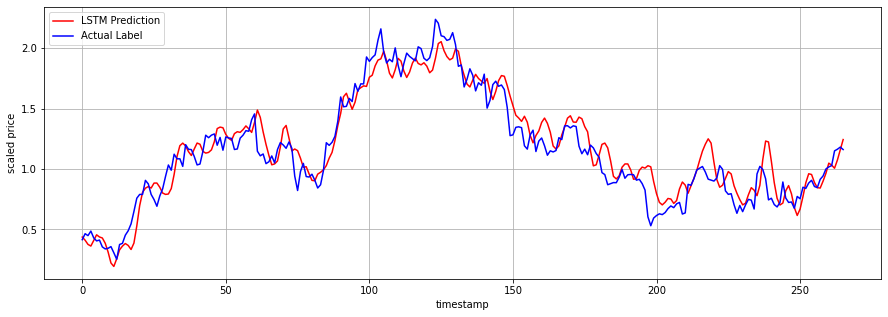

In [23]:
plt.figure(figsize=(15, 5))

plt.plot(preds_test_lstm, color='red', label='LSTM Prediction')
plt.plot(y_test, color='blue', label='Actual Label')
plt.xlabel('timestamp')
plt.ylabel('scaled price')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Bidirectional LSTM

Build a bidirectional LSTM model, very similar to the LSTM above, except a bidirectional layer is added.

In [36]:
bi_lstm = tf.keras.Sequential()
bi_lstm.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
bi_lstm.add(layers.Dropout(0.5))
bi_lstm.add(layers.Bidirectional(layers.LSTM(20, return_sequences=False)))
bi_lstm.add(layers.Dropout(0.5))
bi_lstm.add(layers.Dense(1))
bi_lstm.compile(loss='mse', optimizer=optim)

In [37]:
bi_lstm.fit(X_train, y_train, batch_size=16, epochs=100)

Epoch 1/100
51/51 [==============================] - 11s 9ms/step - loss: 0.0842
Epoch 2/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0451
Epoch 3/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0403
Epoch 4/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0394
Epoch 5/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0372
Epoch 6/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0377
Epoch 7/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0350
Epoch 8/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0373
Epoch 9/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0340
Epoch 10/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0322
Epoch 11/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0344
Epoch 12/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0354
Epoch 13/100
51/51 [================

In [38]:
bi_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 8, 128)            35840     
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 128)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                23840     
_________________________________________________________________
dropout_7 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 59,721
Trainable params: 59,721
Non-trainable params: 0
_________________________________________________________________


### Evaluation

In [39]:
preds_test_blstm = bi_lstm.predict(X_test)

In [40]:
bi_diff = eval_pred(preds_test_blstm, y_test)
print('Average difference: %.2f' % (bi_diff.mean()))

Average difference: 0.15


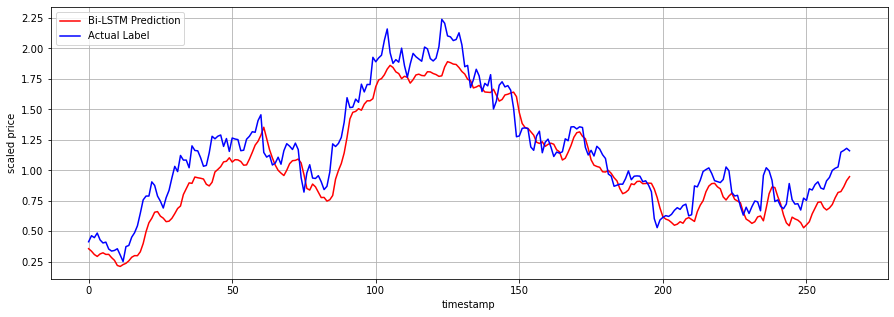

In [41]:
plt.figure(figsize=(15, 5))

plt.plot(preds_test_blstm, color='red', label='Bi-LSTM Prediction')
plt.plot(y_test,color='blue', label='Actual Label')
plt.xlabel('timestamp')
plt.ylabel('scaled price')
plt.legend(loc='upper left')
plt.grid()
plt.show()

## GRU

Here, we are building a Gated Recurrent Unit model, using almost same configurations as the above models.

In [42]:
gru = tf.keras.Sequential()
gru.add(layers.GRU(64, return_sequences=True))
gru.add(layers.Dropout(0.5))
gru.add(layers.GRU(20, return_sequences=False))
gru.add(layers.Dropout(0.5))
gru.add(layers.Dense(1))
gru.compile(loss='mse', optimizer=optim)

In [43]:
gru.fit(X_train, y_train, batch_size=16, epochs=100)

Epoch 1/100
51/51 [==============================] - 7s 8ms/step - loss: 0.1841
Epoch 2/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0981
Epoch 3/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0865
Epoch 4/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0859
Epoch 5/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0667
Epoch 6/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0632
Epoch 7/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0603
Epoch 8/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0549
Epoch 9/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0594
Epoch 10/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0587
Epoch 11/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0586
Epoch 12/100
51/51 [==============================] - 0s 7ms/step - loss: 0.0599
Epoch 13/100
51/51 [=================

In [44]:
gru.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 8, 64)             13632     
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 64)             0         
_________________________________________________________________
gru_3 (GRU)                  (None, 20)                5160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 18,813
Trainable params: 18,813
Non-trainable params: 0
_________________________________________________________________


### Evaluation

In [45]:
preds_test_gru = gru.predict(X_test)

In [46]:
gru_diff = eval_pred(preds_test_gru, y_test)
print('Average difference: %.2f' % (gru_diff.mean()))

Average difference: 0.14


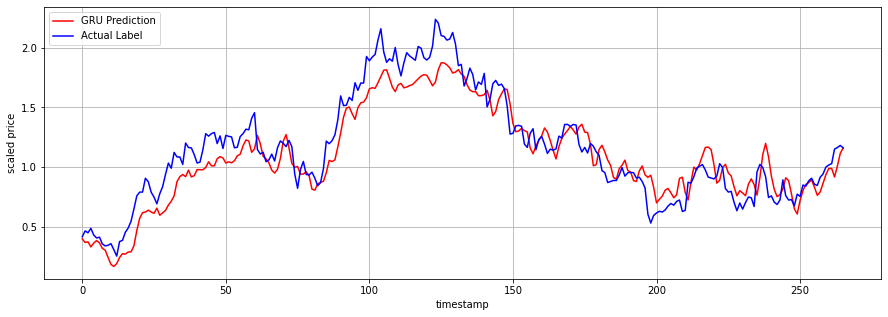

In [47]:
plt.figure(figsize=(15, 5))

plt.plot(preds_test_gru, color='red', label='GRU Prediction')
plt.plot(y_test,color='blue', label='Actual Label')
plt.xlabel('timestamp')
plt.ylabel('scaled price')
plt.legend(loc='upper left')
plt.grid()
plt.show()